## Mars Photogrammetry Preprocessing Pipeline

By Christian Tate, Cornell University; Ithaca, NY

https://github.com/cdt59/MPPP


In [1]:
# Import python modules

import numpy as np
import cv2, glob, time, os
import matplotlib.pyplot as plt
# from planetaryimage import PDS3Image
# import colour_demosaicing
# from PIL import Image
# import matplotlib.cm as cm
# from scipy import interpolate
# from scipy.spatial.transform import Rotation as R
# import colour_demosaicing
# import pandas as pd

%run MPPP.py

%matplotlib inline

In [27]:
# Set input path to IMG files and search criteria


# Set output directory
directory_output = 'Z:/Mastcam-Z/agisoft/images'

# Set input directory
directory_input  = 'Z:/Mastcam-Z/agisoft/data'

directory_input  = 'C:/Users/cdt59/Desktop/Mars_2020_sol_681/data'
directory_output = directory_input

sol = 7

pre = 'Z*0_0'+str(sol)+'*_07'
suf = 'refs_'+str(sol).zfill(3)+'_zcam'

pre = '*F_0'+str(sol)+'*_07'
suf = 'refs_'+str(sol).zfill(3)+'_ecam'

pre = '*V0'+str(sol)+'*_07'
# suf = 'refs_'+str(sol).zfill(3)+'_vec'

pre = ''
suf = 'references'

sequ_id = ''

path_input      = directory_input
IMG_paths = [] 
IMG_paths     += sorted( glob.glob(  directory_input + '/' +pre+'*_N*'+sequ_id+'*.IMG' ) ) 
if 'F_0' in pre or 'V0' in pre: 
    IMG_paths += sorted( glob.glob(  directory_input + '/datadrive/*/ids/rdr/*/' +pre+'*_N*'+sequ_id+'*.IMG' ) ) 
    IMG_paths += sorted( glob.glob(  directory_input + '/datadrive/' +pre+'*_N*'+sequ_id+'*.IMG' ) ) 
if 'Z' in pre: 
    IMG_paths += sorted( glob.glob(  directory_input + '/zcam/sol_0*00s/' +pre+'*_N*'+sequ_id+'*.IMG' ) ) 

# IMG_paths = IMG_paths[:10]

print( len(IMG_paths), 'images\n')
IMG_paths

18 images



['C:/Users/cdt59/Desktop/Mars_2020_sol_681/data\\NLF_0681_0727405223_044RZS_N0321038NCAM03681_0A0185J01.IMG',
 'C:/Users/cdt59/Desktop/Mars_2020_sol_681/data\\NLF_0681_0727405389_535RZS_N0321038NCAM03681_0A0185J01.IMG',
 'C:/Users/cdt59/Desktop/Mars_2020_sol_681/data\\NLF_0681_0727405568_493RZS_N0321038NCAM03681_0A0185J04.IMG',
 'C:/Users/cdt59/Desktop/Mars_2020_sol_681/data\\NLF_0681_0727406027_418RZS_N0321038NCAM02681_0A0195J01.IMG',
 'C:/Users/cdt59/Desktop/Mars_2020_sol_681/data\\NLF_0681_0727406173_197RZS_N0321038NCAM02681_0A0195J01.IMG',
 'C:/Users/cdt59/Desktop/Mars_2020_sol_681/data\\NLF_0681_0727406356_133RZS_N0321038NCAM12681_0A0195J01.IMG',
 'C:/Users/cdt59/Desktop/Mars_2020_sol_681/data\\NLF_0681_0727406502_789RZS_N0321038NCAM12681_0A0195J01.IMG',
 'C:/Users/cdt59/Desktop/Mars_2020_sol_681/data\\NRF_0681_0727405223_044RZS_N0321038NCAM03681_0A0185J01.IMG',
 'C:/Users/cdt59/Desktop/Mars_2020_sol_681/data\\NRF_0681_0727405389_535RZS_N0321038NCAM03681_0A0185J01.IMG',
 'C:/Users

In [28]:
# # remove duplicates in image set

# %run MPPP.py
# remove_duplicate_IMGs( IMG_paths )

18 images

0 NLF_0681_0727405223_044RZS_N0321038NCAM03681_0A0185J01.IMG
The new directory is created:  C:/Users/cdt59/Desktop/Mars_2020_sol_681/data/sols_0600-0699_eng
sol 681 site 32 drive 1038  zenith angle 3432 scale 0.70
 0 NLF_0681_0727405223_044RZS_N0321038NCAM03681_0A0185J01.png	-2377.3825	499.0859	26.5186	189.65	59.9	0


1 NLF_0681_0727405389_535RZS_N0321038NCAM03681_0A0185J01.IMG
sol 681 site 32 drive 1038  zenith angle 3439 scale 0.70
 1 NLF_0681_0727405389_535RZS_N0321038NCAM03681_0A0185J01.png	-2377.6776	499.0301	26.5163	261.82	60.02	0


2 NLF_0681_0727405568_493RZS_N0321038NCAM03681_0A0185J04.IMG
sol 681 site 32 drive 1038  zenith angle 3437 scale 0.69
 2 NLF_0681_0727405568_493RZS_N0321038NCAM03681_0A0185J04.png	-2377.8227	499.2952	26.5185	333.83	59.98	0


3 NLF_0681_0727406027_418RZS_N0321038NCAM02681_0A0195J01.IMG
sol 681 site 32 drive 1038  zenith angle 3421 scale 0.67
 3 NLF_0681_0727406027_418RZS_N0321038NCAM02681_0A0195J01.png	-2377.6121	499.5144	26.5218	46.01	59.7	

<Figure size 640x480 with 0 Axes>

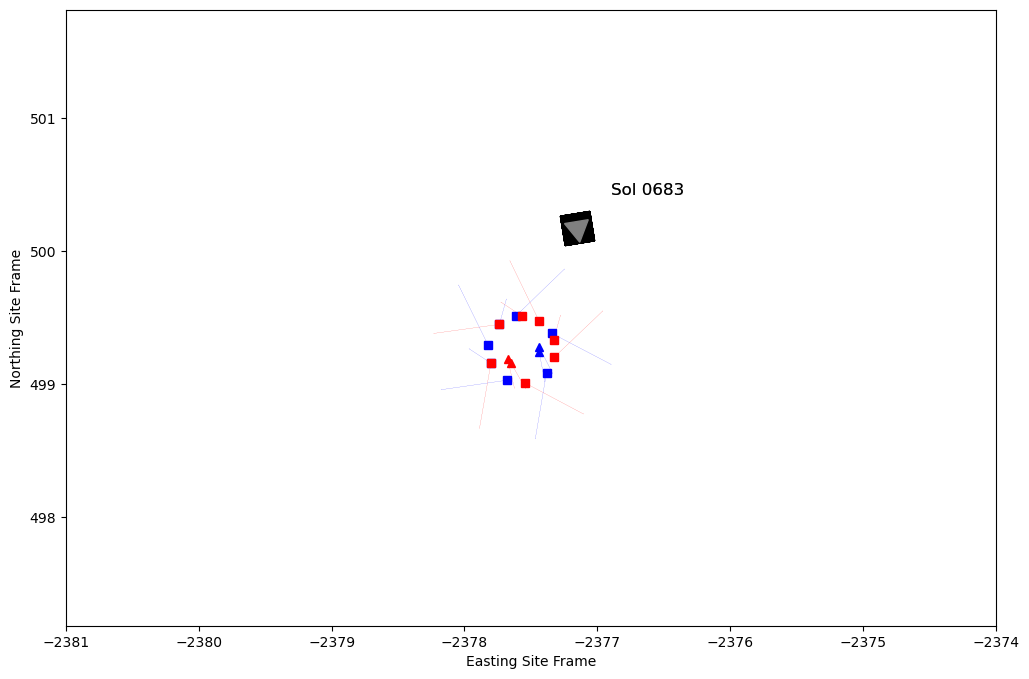

In [29]:
%%time

# time.sleep(1000)

%run MPPP.py

image_list_process( IMG_paths, directory_output, suf, find_offsets_mode = 0 )

In [5]:
def xyz_shift_offsets( site, drive ):
    
    '''
    xyz_shift_offsets finds most accurate Site-Nav offset for each site index and drive
    
    '''

    # print( site, drive )

    parent_path  = os.path.split( os.getcwd() )[0]
    waypoint_shift_path = os.path.join( parent_path, 'params/Mars2020_waypoint_shifts.csv' )

    shift_params = np.loadtxt( waypoint_shift_path, delimiter=',', skiprows=1 )

    site_shifts  = shift_params[ np.where( shift_params[:,1]==site)[0] ]
    site_drives  = site_shifts[:,2]

    if drive in site_drives:
        drive_site_shift = site_shifts[ np.where( site_shifts[:,2]==drive)[0] ][0,:]

    elif drive > site_drives.min() and drive < site_drives.max():
        drive_site_shift = interp1d( site_shifts[:,2], site_shifts, axis=0)(drive)

    elif drive >= site_drives.max():
        drive_site_shift = site_shifts[-1,:]

    else:
        drive_site_shift = np.zeros(12)

    # print( drive_site_shift )
    x_shift, y_shift, z_shift = drive_site_shift[9:]

    # x_shift, y_shift, z_shift = [ 0,0,0 ]
 
    return x_shift, y_shift, z_shift

# def xyz_shift_offsets_add( site, drive ):

In [6]:
import urllib.request, json 
waypoints_url = "https://mars.nasa.gov/mmgis-maps/M20/Layers/json/M20_waypoints.json"

with urllib.request.urlopen( waypoints_url ) as url:
    data = json.loads(url.read().decode())

In [7]:
site  = 34
drive = 0



site3_E = data['features'][0]['properties']['easting']
site3_N = data['features'][0]['properties']['northing']
site3_A = data['features'][0]['properties']['elev_geoid']


    
indexes = [] 
lines   = []

for i in range(len(data['features'])):
    
    site_i = data['features'][i]['properties']['site']
    
    if site_i == site:
        
        sol_i   =  data['features'][i]['properties']['sol']
        drive_i =  data['features'][i]['properties']['drive']
        E_i = np.float64(data['features'][i]['properties']['easting'])   - np.float64(site3_E)
        N_i = np.float64(data['features'][i]['properties']['northing'])  - np.float64(site3_N)
        A_i = np.float64(data['features'][i]['properties']['elev_geoid'])- np.float64(site3_A)
        
        line_i  =   '{}\t{}\t{}\t'.format(sol_i,site_i,drive_i)+\
                    '{:.3f}\t{:.3f}\t{:.3f}\t'.format(0,0,0)+\
                    '{:.3f}\t{:.3f}\t{:.3f}\t'.format( E_i, N_i, A_i )
           
        indexes.append( i )
        lines.append( line_i )
        
lines

['715\t34\t0\t0.000\t0.000\t0.000\t-2867.720\t1421.358\t82.962\t',
 '716\t34\t952\t0.000\t0.000\t0.000\t-2913.638\t1591.495\t86.760\t',
 '717\t34\t2098\t0.000\t0.000\t0.000\t-3005.175\t1762.912\t91.759\t',
 '718\t34\t3196\t0.000\t0.000\t0.000\t-3192.771\t1822.324\t94.970\t',
 '719\t34\t4394\t0.000\t0.000\t0.000\t-3402.497\t1838.044\t106.989\t',
 '721\t34\t5120\t0.000\t0.000\t0.000\t-3433.487\t1767.285\t110.875\t']

In [8]:
lines   = []

for i in range(len(data['features'])):
    
    sol_i   =  data['features'][i]['properties']['sol']
    site_i = data['features'][i]['properties']['site']
    drive_i =  data['features'][i]['properties']['drive']
    
    if drive_i == 0:
        
        E_i = np.float64(data['features'][i]['properties']['easting'])   - np.float64(site3_E)
        N_i = np.float64(data['features'][i]['properties']['northing'])  - np.float64(site3_N)
        A_i = np.float64(data['features'][i]['properties']['elev_geoid'])- np.float64(site3_A)
        
#         line_i  =  '{}\t{}\t{}\t'.format(sol_i,site_i,drive_i)+\
#                     '{:.3f}\t{:.3f}\t{:.3f}\t'.format(0,0,0)+\
#                     '{:.3f}\t{:.3f}\t{:.3f}\t\n'.format( E_i, N_i, A_i )
        line_i  =  [ int(sol_i), int(site_i), int(drive_i), 0, 0, 0, '{:.3f}'.format(E_i), '{:.3f}'.format(N_i),  '{:.3f}'.format(A_i) ]
        print( line_i )
        lines.append( line_i )


[13, 3, 0, 0, 0, 0, '0.000', '0.000', '0.000']
[84, 4, 0, 0, 0, 0, '78.194', '-24.177', '0.610']
[130, 5, 0, 0, 0, 0, '47.200', '-525.883', '-0.724']
[157, 6, 0, 0, 0, 0, '42.959', '-1003.669', '-15.012']
[180, 7, 0, 0, 0, 0, '-366.571', '-823.192', '-4.614']
[248, 8, 0, 0, 0, 0, '-442.276', '-632.051', '0.756']
[286, 9, 0, 0, 0, 0, '-534.830', '-709.314', '-4.528']
[359, 10, 0, 0, 0, 0, '56.611', '-233.380', '0.191']
[361, 11, 0, 0, 0, 0, '87.262', '-43.457', '1.188']
[381, 12, 0, 0, 0, 0, '193.350', '258.971', '0.154']
[382, 13, 0, 0, 0, 0, '452.860', '389.596', '-1.292']
[385, 14, 0, 0, 0, 0, '621.342', '750.545', '1.089']
[387, 15, 0, 0, 0, 0, '601.229', '1176.533', '2.169']
[389, 16, 0, 0, 0, 0, '199.910', '1403.036', '6.720']
[394, 17, 0, 0, 0, 0, '71.503', '1397.758', '7.793']
[396, 18, 0, 0, 0, 0, '-277.375', '1348.107', '12.167']
[399, 19, 0, 0, 0, 0, '-664.104', '1151.764', '12.919']
[402, 20, 0, 0, 0, 0, '-1174.414', '947.725', '17.851']
[405, 21, 0, 0, 0, 0, '-1636.261', '7

## Ignore the notes below

In [9]:
# '''
# df_refs : pandas dataframe that holds reference info for each image

# data saves in the output directory as a CSV file 'df'+output+'.csv' and as a python pickle 'df'+output+'.pkl'

# '''

# df_refs = pd.DataFrame( 
#     columns = [ 
#         'sol',           # sol number or Mars day since landing is a natural way to describe images.
#         'site',          # site index for the rover's location, site 3 is the landing site
#         'drive',         # drive index is where the rover is relative to the current site frame
#         'time',          # datetime of image capture
        
#         'xyz_enu',       # postition XYZ values in meters ENU = [xEast, yNorth, zUp ] from site 3 (note: as Metashape interprets XYZ)
#         'xyz_ned',       # postition XYZ values in meters NED = [xNorth, yEast, zDown] from site 3
#         'rot_rpy',       # rotation angles in RPY = [roll, pitch, yaw] in degrees (as Metashape interprets roll-pitch-yaw)
#         'rot_ypr',       # rotation angles in YPR = [yaw, pitch, roll] in degrees 
#         'rot_opk',       # rotation angles in OPK = [omega, phi, kappa] in degrees 
        
#         'site_wy',       # waypoint site index, same as the current site if 'site_wy' == 'site' 
#         'drive_wp',      # waypoint drive index, same as the current drive if 'drive_wy' == 'drive'      
#         'xyz_wp',        # waypoint postition XYZ values in meters NED = [xNorthing, yEasting, zElevation]
#         'xyz_site3'      # postition of site3 (OEB landing site) in meters NED = [xNorth, yEast, zDown], 'xyz_site3'=[0,0,0] if site3 is the default reference frame
#         'nee_site3'      # postition of site3 (OEB landing site) in meters NED = [xNorthing, yEasting, zElevation]
#         'lle_site3'      # postition in [longitude, latitude, elevation] Mars global coordinates        
       
#         'cahvor',        # the CAHVOR or CAHVORE camera model in rover frame [xFront, yRight, zDown]
#         'az_site',       # site-frame azimuth pointing in degrees clockwise from the North vector 
#         'el_site',       # site-frame elevation pointing in degrees positive from the horizone
#         'az_rover',      # rover-frame azimuth pointing in degrees clockwise from the rover's forward vector
#         'el_rover',      # rover-frame elevation pointing in degrees positive from the forward-right plane       
        
#         'ref',           # string that forms the image's line in the reference file for import to software (Metashape)
#         'filename',      # file name with .IMG extension
#         'filepath',      # complete file path to image at run time
# ])


# df_refs

In [10]:
# ignore the below cells

In [11]:
# For find_offset_mode = 1

# # pos_lines  = []
# # rover_xyzs = []
# # im_xyzs    = []
# # sols       = []
# # rmcs = []
sites  = [ rmcs[i][0] for i in range(len(rmcs))[::-1] ]
drives = [ rmcs[i][1] for i in range(len(rmcs))[::-1] ]
Xs     = [ rover_xyzs[i][0] for i in range(len(rover_xyzs))[::-1] ]
Ys     = [ rover_xyzs[i][1] for i in range(len(rover_xyzs))[::-1] ]
Zs     = [ rover_xyzs[i][2] for i in range(len(rover_xyzs))[::-1] ]

table = np.stack( [sols[::-1], sites, drives, Xs, Ys, Zs], axis=1)
np.round( table, 4 )

np.savetxt( directory_output+"/offsets.csv", table, delimiter="\t")

NameError: name 'rmcs' is not defined

In [ ]:
# Scam flatfield

path = 'C:/Users/cornell/Mastcam-Z/ws/seitah'
pre = 'L*_0510*'

RAD_paths = [] \
          + sorted( glob.glob(  path + '/' +pre+'*R*_N*.IMG' ) ) \

RAD_paths

ims = []
for i in range(len(RAD_paths))[:]:
    
    im_image = PDS3Image.open( RAD_paths[i] ).image
    ims.append( np.float64( im_image) )
    
flat = np.mean( ims, axis=0)
for i in range(3):
    flat[:,:,i] /= np.mean( flat[700:-700,700:-700,i] )
    
plt.imshow( flat/1.5 )

In [ ]:
x = np.arange(0, 2048)
y = np.arange(0, 2048)
xv, yv = np.meshgrid(x, y)

y0, x0, r0, p = [900,1000,1000,3]
dv = ( (xv-x0)**2 + (yv-y0)**2 )**(p/2)
dv /= (r0**p)*2
dv += 1

# lim = .8
# dv[ dv<lim]  =lim

dflat = flat.copy()
for i in range(3):
    dflat[:,:,i] *= dv
    
plt.imshow( dflat/2 )
plt.colorbar()

In [ ]:
dvl = np.mean( dflat[:,1000:1300], axis=1)
plt.plot(dvl)

dvl = np.mean( flat[:,1000:1300], axis=1)
plt.plot(dvl)
# flat = dflat.copy()

In [ ]:
import urllib.request, json 

'''

https://mars.nasa.gov/mmgis-maps/M20/Layers/json/M20_waypoints.json

https://docs.google.com/spreadsheets/d/1GSNJL-e5iROCaKUC4BXL_OA8hWy8vUdfCN7levRNkZA/edit#gid=1232397498

''' 
# path =  'C:/Users/cornell/Downloads/M20_waypoints.json'
# with open( path ) as f:
#     data = json.load(f)

with urllib.request.urlopen("https://mars.nasa.gov/mmgis-maps/M20/Layers/json/M20_waypoints.json") as url:
    data = json.loads(url.read().decode())

    
site3_E = data['features'][0]['properties']['easting']
site3_N = data['features'][0]['properties']['northing']
site3_A = data['features'][0]['properties']['elev_geoid']


for i in range(len(data['features']))[::-1]:
    
    print( data['features'][i]['properties']['sol'],'\t',
           data['features'][i]['properties']['site'], '\t',
           data['features'][i]['properties']['drive'],'\t',
           ''+'\t',''+'\t',''+'\t',
           np.round( np.float64(data['features'][i]['properties']['easting'])- np.float64(site3_E), 3),'\t',
           np.round( np.float64(data['features'][i]['properties']['northing'])- np.float64(site3_N), 3),'\t',
           np.round( np.float64(data['features'][i]['properties']['elev_geoid'])- np.float64(site3_A), 3),'\t',
         )